In [1]:
from qiskit import QuantumCircuit, transpile,execute
from qiskit_aer import AerSimulator
from qiskit.extensions import UnitaryGate
from qiskit.visualization import plot_histogram, array_to_latex
from IPython.display import display, Math
from qiskit.quantum_info import DensityMatrix, partial_trace
import numpy as np
from math import sqrt

In [2]:
sim = AerSimulator()

## POVM measurement statistics
We know that we can realize any general measurement $\{M_i\}_{i = 1}^n$ [such that $\sum M_i^{\dagger}M_i = I$] as a projective measurement on a system that 
has $m$ more dimensions.

This can be done by first carrying out a unitary operation on the joint system and then performing a projective measurement exclusively on the ancillary part.

In this question we try and get to the measurement statistics of a POVM through another way.

The key idea here is to note that $$\mathrm{Pr} (outcome = m) = \mathrm{tr} (E_m\rho) = \mathbb{E}_{\rho}(E_m)$$ where $E_m = M_m^\dagger M_m$ is an observable, and $\mathbb{E}_\rho(E_m)$ is the expected outcome in the _projective_ measurement of $E_m$. Please prove the aforementioned equality below.

Proof:


## Part 1
So computing the measurement statistics of the measurement ${M_m}_m$ reduces to computing the expectation values in projective measurements of the $E_m$ s. How might we do this? For starters, if $E_m$ was diagonalizable in the computational basis, then we are more or less done - we must just create a huge ensemble of states in $\rho$, measure them in the comp. basis, collect the empirical probabilities of each outcome and compute the expectation of $E_m$. But what is some $E_m$ is not diagonal in the computational basis? Well, that's trivial, measure them in that basis! - The issue here, is that measuring in the computational basis is "easy", but not so to measure in an arbitrary basis. We use the change of basis trick to turn the basis $|a_i\rangle$ of $E_m$ into the computational basis by applying to $\rho$ the unitary $U = \sum_i |i\rangle\langle a_i|$. Convince yourself that measuring the new state in the computational basis gives you identical statistics as measuring the original state in the basis $|a_i\rangle$. There you go - by modifying the state via a unitary, we can measure any $E_m$. Let's implement this in Qiskit below:

In [3]:
def measure_obs(qckt: QuantumCircuit, obs: np.ndarray, shots=2000) -> tuple:
    # You are given a circuit on running which leaves an initial system in state rho. Apply the change of basis matrix (look up numpy functions to compute eigenvectors) and complete the circuit by measuring it.

   # assert np.all(np.conjugate(obs).T == obs), 'given array is not an observable'
    n = obs.shape[0]
    #assert 2**len(qckt.qubits) == n, 'observable not of the right size for circuit'
    
    evals, evecs = np.linalg.eig(obs) # you might find these useful :)
    U = np.conjugate(evecs).T # compute the expectation value of the observable by simulating the circuit for `shots` shots.
    dm = partial_trace(DensityMatrix(qckt), [i for i in range(1,len(qckt.qubits))])
    dm = np.matmul(U, dm)
    dm = np.matmul(dm, np.conjugate(U).T)
    qckt.measure(0,0)

    job = execute(qckt, sim, shots = shots)
    counts = job.result().get_counts()

    expval = 0

    for key, value in counts.items():
        expval += value * evals[int(key[0])]
    expval /= shots         
    # ... your code ... #

    return qckt, expval

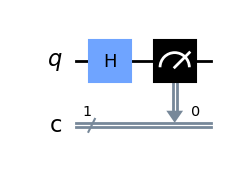

Expected value: 0.001


In [4]:
# a quick test - add your own.
ckt = QuantumCircuit(1, 1); ckt.h(0)
obs = np.array([[1, 0], [0, -1]])
ckt, expval = measure_obs(ckt, obs)
display(ckt.draw('mpl'))
print("Expected value:" , expval)

## Part 2
1. Suppose we have the following set $$\{E_1 = \alpha \ket{0}\bra{0}, E_2 = \beta \ket{+}\bra{+}, E_3 = I - E_1 - E_2\}$$
Figure out the constraints on $\alpha$, $\beta$ for this to be a valid POVM.
2. Now, suppose that Alice gives Bob a qubit which is in state $\ket{0}$ with probability $p_1 = 0.5$ and in state $\ket{+}$ with probability $p_2 = 0.5$. Bob performs the above POVM on it. Outcome 3 in this case corresponds to his "Don't know" answer.
Use the circuit from part(1) to approximate the probability of this. Compare with the theoretical answer. [Do this for any _valid_ pair of $\alpha, \beta$. Play around with the values to minimize the "Don't Know" probability]

Of course you are free to use the function above.

In [14]:
shots = 2000
alpha = 2 - sqrt(2)
beta = 2 - sqrt(2)

e1 = np.array([[0, 0], [0, alpha]])
e2 = np.array([[beta/2, -beta/2], [-beta/2, beta/2]])
e3 = np.array([[1,0],[0,1]]) - e1 - e2

qckt = QuantumCircuit(2,1)
qckt.initialize([1/sqrt(2), 1/2, 0 , 1/2])

evals, evecs = np.linalg.eig(e3) # you might find these useful :)
U = np.conjugate(evecs).T # compute the expectation value of the observable by simulating the circuit for `shots` shots.
qckt.unitary(U, [0])
qckt.measure(0,0)

job = execute(qckt, sim, shots = shots)
counts = job.result().get_counts()

expval = 0

for key, value in counts.items():
    expval += value * evals[int(key[0])]
expval /= shots

print(expval)

0.6333325368684622
